# GAMALOS (GAlaxies MAking LOve Simulation)

## Theoric remarks

Report: write a short report containing:
- a short introduction to the N-body problem, the difference between
collisional and collisionless systems and the force estimate in
collisionless simulations based on tree algorithms. Short general
description of the fireworks package and its implementation.
- Description of the methods (integrators, force estimator) used.
- Description of the initial conditions and simulation setup.
- Results and discussion. They depends on the specific project you
chose, but I expect at least one plot showing the main conclusion of
your analysis.

<div class='alert alert-danger' role='alert'>
Inserisci info teoriche
</div>

## Computation

In [1]:
#first of all, we import all the packages for Particles, integrators, ic...

import numpy as np
import pandas as pd
from fireworks.ic import ic_two_body
import matplotlib.pyplot as plt
from fireworks.nbodylib.integrators import integrator_euler, integrator_leapfrog_galaxy, integrator_leapfrog, integrator_rungekutta
from fireworks.nbodylib.dynamics import acceleration_direct_vectorized, acceleration_direct, acceleration_pyfalcon, acceleration_jerk_direct
from fireworks.particles import Particles
from typing import Optional, Tuple, Callable, Union
import time

#from mpl_toolkits.mplot3d import Axes3D

%matplotlib widget

We can import the data of one galaxy at first. The units are still Nbody units.

In [2]:
df_0 = pd.read_csv("data_cvs/Nbody_disc.csv")

# slice dataframe
num_particles = 1e3
df = df_0.iloc[:int(num_particles)]

df.head(10)

,mass,x,y,z,vx,vy,vz
0,1.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000,0.0
1,1.000000e-11,-3.419583,-1.901788,0.0,0.118878,-0.213752,0.0
2,1.000000e-11,-14.046839,-2.403541,0.0,0.040952,-0.239330,0.0
3,1.000000e-11,-4.618003,6.269821,0.0,-0.222721,-0.164044,0.0
4,1.000000e-11,-6.045516,0.257974,0.0,-0.011730,-0.274897,0.0
5,1.000000e-11,-1.393104,1.578234,0.0,-0.124900,-0.110249,0.0
6,1.000000e-11,-1.150877,-1.762433,0.0,0.139480,-0.091081,0.0
7,1.000000e-11,0.593887,-1.003781,0.0,0.086283,0.051049,0.0
8,1.000000e-11,2.423492,-10.266498,0.0,0.257402,0.060762,0.0
9,1.000000e-11,-3.279328,5.118040,0.0,-0.231783,-0.148512,0.0


### 1. Initial conditions
We generated a Particles instance for each galaxy

In [3]:
# create a class with the mass, pos, vel of each element of the Galaxy

masses = df[['mass']]
positions = df[['x', 'y', 'z']]
velocities = df[['vx', 'vy', 'vz']]

# reshape mass array as 1D array
masses = masses.values.reshape(-1)

Galaxy1 = Particles(positions.values, velocities.values, masses)
print(Galaxy1.pos.shape)

(1000, 3)


In [4]:
# do the same for the other galaxy
# this second galaxy is the same as the first one, but translated by a certain value

pos_translation = np.array((40., 20., 0.))
vel_translation = np.array((-0.2, 0., 0.))

# apply this translation to find the second galaxy

positions_gal_2 = positions.values + pos_translation
velocities_gal_2 = velocities.values + vel_translation
Galaxy2 = Particles(positions_gal_2, velocities_gal_2, masses)

### Rotation curve and Surface density profile
Let's plot the rotation curve and the surface density profile for one galaxy, in particular for Galaxy 1. 

The **rotation curve** of a galaxy shows the azimuthal velocity as function of the cylindrical radius . To estimate the azimuthal velocity for each particle we transform the Cartesian coordinates to cylindrical: 

$$
\begin{cases}
R_{\text{cyl}} = \sqrt(x^2+y^2) \\
\phi = \arctan(\frac{y}{x}) \\
z=z
\end{cases}
$$

We then computed the azymuthal velocity for all the particles using: 
$$
V_\phi = V_y \cdot \cos(\phi) - V_x\cdot \sin(\phi)
$$

We then plotted $V_\phi$ vs $R$ to obtain the rotation curve of the galaxy. 

The **surface density profile** $\Sigma$ shows the amount of mass in a cylindrical ring divided by the area of the ring. To estimate it we bin the particles on the cylindrical radius $R_{\text{cyl}}$, then we sum all the masses of the particles to obtain $M_{\text{tot, ring}}$ and then the area of the ring is given by $\pi (R^2_{\text{outer}}-R^2_{\text{inner}})$ where $R_{\text{inner}}$ and $R_{\text{outer}}$ are the borders of the considered bin. Finally $\Sigma_{\text{ring}}=M_{\text{tot, ring}}/A_{\text{ring}}$. 

We plotted the initial number suface density of the disc, which means that we use the number of particles instead of the total mass of the ring, as function of the cylindrical radius. 

In [5]:
def rotation_curve(x, y, z, vx, vy):
    # convert to cylindrical coordinates
    Rcyl = np.sqrt(x ** 2 + y ** 2)                   # cylindrical radius
    phi = np.arctan2(y, x)                            # azimuthal angle
    z = z                                             # z-coordinate

    # compute azimuthal velocity    
    vel_phi = vy * np.cos(phi) - vx * np.sin(phi)     # azimuthal velocity

    return Rcyl, vel_phi

def surface_density(Rcyl):
    H, edge = np.histogram(Rcyl, bins=20)                                          # histogram of the cylindrical radius
    area =  np.pi * (edge[1:]**2 - edge[0:-1]**2)                                  # area of every bin (every concentric ring) 
    mid = 0.5 * (edge[1:] + edge[0:-1])                                            # midpoint of every bin  

    return mid, H, area

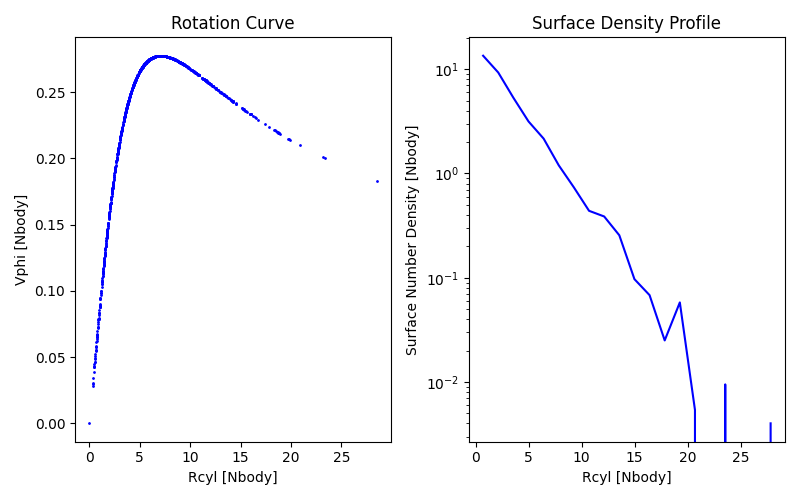

In [6]:
# compute rotation curve and surface density
Rcyl, vel_phi = rotation_curve(Galaxy1.pos[:, 0], Galaxy1.pos[:, 1], Galaxy1.pos[:, 2], Galaxy1.vel[:, 0], Galaxy1.vel[:, 1])
mid, H, area = surface_density(Rcyl)

# rotation curve plot
plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
plt.plot(Rcyl, vel_phi, 'o', markersize=1, c='b')
plt.xlabel("Rcyl [Nbody]")
plt.ylabel("Vphi [Nbody]")
plt.title("Rotation Curve")

# surface density plot
plt.subplot(1, 2, 2)
plt.yscale('log')
plt.plot(mid, H / area, c='b')
plt.xlabel("Rcyl [Nbody]")
plt.ylabel("Surface Number Density [Nbody]")
plt.title("Surface Density Profile")

plt.tight_layout()
plt.show()  


### Initial configuration of the galaxies

Text(0.5, 1.0, 'Galaxies 1 and 2 - intial positions')

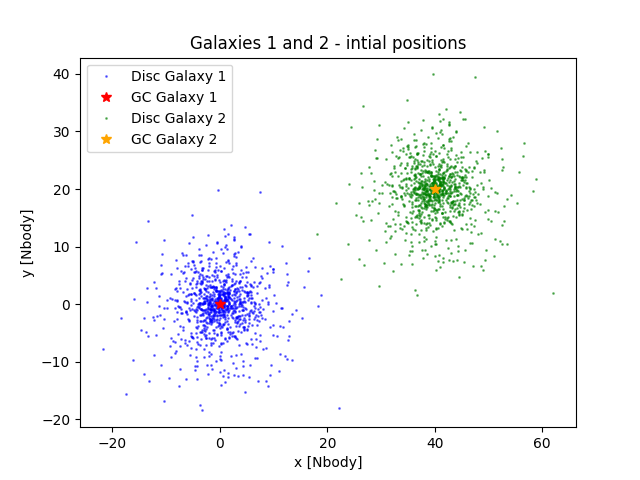

In [7]:
plt.figure()
plt.plot(Galaxy1.pos[1:,0], Galaxy1.pos[1:,1], 'o', markersize=1, c='b', label='Disc Galaxy 1', alpha=0.5)
plt.plot(Galaxy1.pos[0,0], Galaxy1.pos[0,1], '*', markersize=7, c='r', label='GC Galaxy 1')

plt.plot(Galaxy2.pos[1:,0], Galaxy2.pos[1:,1], 'o', markersize=1, c='g', label='Disc Galaxy 2', alpha=0.5)
plt.plot(Galaxy2.pos[0,0], Galaxy2.pos[0,1], '*', markersize=7, c='orange', label='GC Galaxy 2') 
plt.legend()

plt.xlabel('x [Nbody]')
plt.ylabel('y [Nbody]')
plt.title('Galaxies 1 and 2 - intial positions')

### Orbital integration of Galaxy 1
Let's try an orbital simulation of the first galaxy to see if the integration works (in this test we used the leap-frog method).

In [8]:
# First we calculate the period of the galaxy (approximatly, I'm not sure if is the right method)
# with the formula T = 2*pi*sqrt(a^3/GM).
# We're in n-body units so G=1 and for the radius I take the maximum distance from the centre of the galaxiy (a = r_max)
# and we suppose a cicurlar orbits so e=0

plummer_scale_lenght = 5.              # scale lenght of the plummer sphere
e = 0.                                  # eccentricity
radius = np.max(Galaxy1.radius())       # radius of the galaxy
print(f'radius of the galaxy: {radius}')

a = radius / (1 - e)                    # semi-major axis
M = Galaxy1.mass[0]                     # taking the mass of center of mass

T = 2*np.pi*np.sqrt(a**3/M)             # period of the galaxy

print(f'Period of the galaxy (approximately): {T}')

# Now we can define the time of simulation and the number of steps
t0 = 0.                         # initial time
tsimulation = 1*T              # time of simulation
N = int(1e4)                    # number of steps
h = (tsimulation - t0)/N        # time steps


def integration_leapfrog_adaptive(galaxy: Particles, h: float, tsimulation: float, t: float, soft: float):

    N = len(galaxy.mass)         # number of particles in the galaxy
    path = [galaxy.pos]
    velocity = [galaxy.vel]
    time   = [t]
    timestep = [h]
    
    Etot_leapfrog = []
    Ekin_leapfrog = []
    Epot_leapfrog = []

    while t < tsimulation:
        result = integrator_leapfrog_galaxy(particles=galaxy, tstep=h, acceleration_estimator=acceleration_pyfalcon, softening=soft)
        updated_galaxy, updated_acc, _, _ = result
        path.append(updated_galaxy.pos)
        velocity.append(updated_galaxy.vel)
            
        Etot_n, Ekin_n, Epot_n = updated_galaxy.Etot_vett()
        Etot_leapfrog.append(Etot_n)
        Ekin_leapfrog.append(Ekin_n)
        Epot_leapfrog.append(Epot_n)
        
        #ts_1, _, _ = adaptive_timestep_r(galaxy)
        #h = ts_1
        timestep.append(h)
        t += h
        time.append(t)


    path = np.array(path)
    velocity = np.array(velocity)
    time   = np.array(time)
    timestep  = np.array(timestep)

    Etot_leapfrog = np.array(Etot_leapfrog)
    Ekin_leapfrog = np.array(Ekin_leapfrog)
    Etot_leapfrog = np.array(Epot_leapfrog)

    return path, velocity, Etot_leapfrog, Ekin_leapfrog, Epot_leapfrog, time, timestep
                                                                                          

radius of the galaxy: 28.519092594716312
Period of the galaxy (approximately): 956.9371681553022


In [9]:
Galaxy1_test = Galaxy1.copy()

Galaxy1_orbit, Galaxy1_stars_vel, Galaxy1_Etot, Galaxy1_Ekin, Galaxy1_Epot, Galaxy1_time, Galaxy1_timestep = integration_leapfrog_adaptive(galaxy=Galaxy1_test, h=h, 
                                                                                            tsimulation=tsimulation, t=t0, soft=plummer_scale_lenght)

/root/miniconda3/lib/python3.10/site-packages/fireworks-0.0.5-py3.10.egg/fireworks/particles.py:275: RuntimeWarning: divide by zero encountered in divide


In [10]:
print(Galaxy1_orbit.shape)
# (iterations, particles, coordinates)

(10002, 1000, 3)


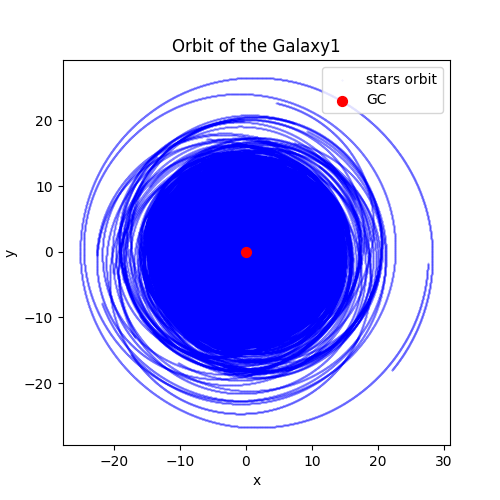

In [11]:
plt.figure(figsize=(5,5))
plt.scatter(Galaxy1_orbit[:,1:,0], Galaxy1_orbit[:,1:,1], s=0.1, color='blue', label='stars orbit', alpha=0.1)
plt.scatter(Galaxy1_orbit[0,0,0], Galaxy1_orbit[0,0,1], s=50, color='red', label='GC')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Orbit of the Galaxy1')
plt.legend(loc='upper right')
plt.show()

We check the total energy error of our simulation. We define a general function we can use for all the simulations. 

In [12]:
def total_energy_error(Etot, initial_t, tsimulation, h):
    energy_error = np.zeros_like(Etot)

    for i in range(len(Etot)):
        energy_error[i] = np.abs((Etot[i] - Etot[0])/Etot[0])

    time = np.arange(0, tsimulation, h)

    return energy_error, time

In [17]:
'''
# calculate the error of the total energy for Galaxy1

energy_error, time = total_energy_error(Etot=Galaxy1_Etot, initial_t=t0, tsimulation=tsimulation, h=h)


# plot the error of the total energy for Galaxy1
plt.figure(figsize=(5,5))
plt.plot(time, energy_error, label='Galaxy1')
plt.xlabel('time')
plt.ylabel('energy error')
plt.title('Total energy error for the Galaxy1')
plt.legend()
plt.show()
'''

"\n# calculate the error of the total energy for Galaxy1\n\nenergy_error, time = total_energy_error(Etot=Galaxy1_Etot, initial_t=t0, tsimulation=tsimulation, h=h)\n\n\n# plot the error of the total energy for Galaxy1\nplt.figure(figsize=(5,5))\nplt.plot(time, energy_error, label='Galaxy1')\nplt.xlabel('time')\nplt.ylabel('energy error')\nplt.title('Total energy error for the Galaxy1')\nplt.legend()\nplt.show()\n"

### Stability of the rotation curve

In [21]:
# intiial rotation curve
Rcyl, vel_phi = rotation_curve(Galaxy1.pos[:, 0], Galaxy1.pos[:, 1], 
                               Galaxy1.pos[:, 2], Galaxy1.vel[:, 0], Galaxy1.vel[:, 1])

# rotation curve after the simulation
Rcyl_end, vel_phi_end = rotation_curve(Galaxy1_orbit[-1,:,0], Galaxy1_orbit[-1,:,1],
                                        Galaxy1_orbit[-1,:,2], Galaxy1_stars_vel[-1,:,0], Galaxy1_stars_vel[-1,:,1])


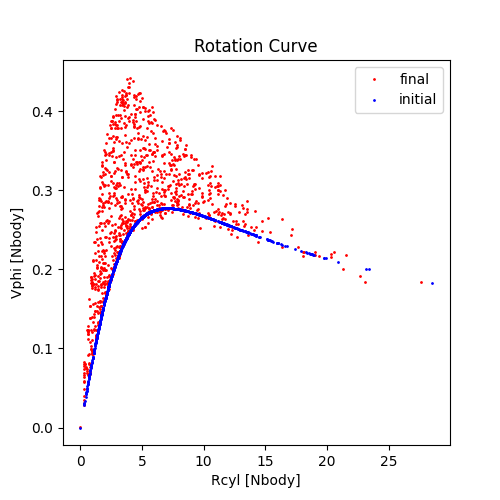

In [22]:
plt.figure(figsize=(5,5))
plt.plot(Rcyl_end, vel_phi_end, 'o', markersize=1, c='r', label='final')
plt.plot(Rcyl, vel_phi, 'o', markersize=1, c='b', label='initial')
plt.xlabel("Rcyl [Nbody]")
plt.ylabel("Vphi [Nbody]")
plt.title("Rotation Curve")
plt.legend()
plt.show()
